In [1]:
import random
import os
import csv
from dataclasses import dataclass
import time
from collections import defaultdict

import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
# Set device and CPU threads
from multiprocessing import cpu_count
torch.set_num_threads(cpu_count())
print(f'Using {torch.get_num_threads()} threads')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device {device}')

Using 32 threads
Using device cuda:0


In [3]:
# Tokenizer
NOTES = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
NOT_VOICE_TOKEN = '<N>'
END_OF_FILE_TOKEN = '<EOF>'

ALLOWED_TOKENS = []
for octave in [2,3,4,5]:
    o = str(octave)
    for n in NOTES:
        ALLOWED_TOKENS.append(n+o)

stoi = {s:i+1 for i,s in enumerate(ALLOWED_TOKENS)}
stoi[NOT_VOICE_TOKEN] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [4]:
# NUM_SECONDS seconds of data * around 87 pitch readings per second
NUM_SECONDS = 10
BLOCK_SIZE = 87 * NUM_SECONDS + 90
NOISE_WINDOW_SIZE = 10

In [5]:
# CLASS NAMES - NOTE: Do not change numbering.
CLASS_NAMES = {
    'saveri': 0,
    'hemavati': 1
}

In [6]:
@dataclass
class PitchDataFile:
    file_path: str
    pitches: list
    

In [7]:
# For initial tests, keep entire data in memory. Keep only the pitch list.
pitch_data_dir = '../../data/simple-test/pitch_data'

X = []
pitch_data = {}
# Consider every 30 second segment with a hop of 5 second
# So (0, 30), (5, 35), (10, 40) and so on 
#sample_hop_length = 87 * 1
# Consider every BLOCK_SIZE second segment
sample_hop_length = 1

for class_name in os.listdir(pitch_data_dir):
    if class_name not in CLASS_NAMES:
        print(f'{class_name} not included for training')
        continue
    class_dir = os.path.join(pitch_data_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        data = []
        print(f'processing {file_path}')
        with open(file_path, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                if len(row) >= 3:
                    data.append(row[2])
            ########################################################
            ## NOTE ################################################
            ## Remove noise token - add noise padding on sides instead
            #########################################################
            pitches = [stoi[x] for x in data if x != NOT_VOICE_TOKEN]
            #pitches = [stoi[NOT_VOICE_TOKEN]] * NOISE_WINDOW_SIZE + pitches + [stoi[NOT_VOICE_TOKEN]] * NOISE_WINDOW_SIZE
            print(f'pitches length: {len(pitches)}')
            #########################################################
            pd = PitchDataFile(file_path=file_path, pitches=pitches)
            sampling_data = [(file_path, i, CLASS_NAMES[class_name]) for i in range(0, len(pitches) - BLOCK_SIZE - 1, sample_hop_length)]
            X.extend(sampling_data)
            pitch_data[file_path] = pd

print(f'Total data: {len(X)}')

processing ../../data/simple-test/pitch_data/hemavati/trichur-hemavati-alapana_C#3_minus_1
pitches length: 31320
processing ../../data/simple-test/pitch_data/hemavati/trichur-hemavati-alapana_C#3_plus_1
pitches length: 33121
processing ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3
pitches length: 91679
processing ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_plus_3
pitches length: 87309
processing ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_minus_1
pitches length: 85594
processing ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_minus_2
pitches length: 84056
processing ../../data/simple-test/pitch_data/hemavati/trichur-hemavati-alapana_C#3_plus_3
pitches length: 32643
processing ../../data/simple-test/pitch_data/hemavati/trichur-hemavati-alapana_C#3
pitches length: 37643
processing ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_plus_2
pitches length: 87185
processing ../../data/simple-test/pitch_data/hemavati/arun

In [8]:
from torch.utils.data import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader

def get_in_dict_form(X, Y):
    d = defaultdict(list)
    for i, val in enumerate(Y):
        d[val].append(X[i])
    return d

def fetch_data(xtr, idx):
    tmp = []
    for i in idx:
        file_path = xtr[i][0]
        start_index = xtr[i][1]
        v = pitch_data[file_path].pitches[start_index:start_index+BLOCK_SIZE]
        tmp.append(pitch_data[file_path].pitches[start_index:start_index+BLOCK_SIZE])
    return torch.tensor(tmp, device=device, dtype=torch.int).squeeze()

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #print('here')
        return fetch_data(self.X, [idx]), self.y[idx]
            
#Xt, yt = [tuple(t[:2]) for t in X], [t[2] for t in X]
#Xtrain, Xrest, Ytrain, Yrest = train_test_split(Xt, yt, test_size=0.2, random_state=42,stratify=yt)
#Xdev, Xtest, Ydev, Ytest = train_test_split(Xrest, Yrest, test_size=0.5, random_state=42,stratify=Yrest)
#print(f'Xt shape: {len(Xt)}, Yt shape: {len(yt)}')
#print(f'Xtrain shape: {len(Xtrain)} Ytrain shape: {len(Ytrain)}')
#print(f'Xtest shape: {len(Xtest)} Ytest shape: {len(Ytest)}')
#print(f'Xdev shape: {len(Xdev)} Ydev shape: {len(Ydev)}')

In [9]:
######################################
# Old training method
######################################


random.shuffle(X)
train_size = int(0.8 * len(X))
dev_size = int(0.1 * len(X))



# Split the data
train_data = X[:train_size]
dev = X[train_size:train_size + dev_size]
test = X[train_size + dev_size:]

Xtrain, Ytrain = [tuple(t[:2]) for t in train_data], [t[2] for t in train_data]
Xdev, Ydev = [tuple(t[:2]) for t in dev], [t[2] for t in dev]
Xtest, Ytest = [tuple(t[:2]) for t in test], [t[2] for t in test]

print(f'Xtrain size: {len(Xtrain)}, Ytrain size: {len(Ytrain)}')
print(f'Xdev size: {len(Xdev)}, Ydev size: {len(Ydev)}')
print(f'Xtest size: {len(Xtest)}, Ytest size: {len(Ytest)}')

ytrain_numpy = np.array(Ytrain)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(ytrain_numpy), y=ytrain_numpy)
class_weights = torch.tensor(class_weights, device=device, dtype=torch.float32)
print(f'Sklearn class_weights: {class_weights}')

Ytrain = torch.tensor(Ytrain, device=device)
Ydev = torch.tensor(Ydev, device=device)
Ytest = torch.tensor(Ytest, device=device)

Xtrain size: 984303, Ytrain size: 984303
Xdev size: 123037, Ydev size: 123037
Xtest size: 123039, Ytest size: 123039
Sklearn class_weights: tensor([1.1156, 0.9061], device='cuda:0')


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet_1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, n_embd, n_tokens, device='cpu', dropout=0.1):
        super().__init__()
        
        # For pickling
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.n_embd = n_embd
        self.n_tokens = n_tokens
        self.dropout = dropout
        
        self.emb = nn.Embedding(n_tokens, n_embd, device=device)
        self.ConvNet = nn.Sequential(
            nn.Conv1d(n_embd, 32, kernel_size=kernel_size, device=device),
            nn.ReLU(),
            nn.BatchNorm1d(32, device=device),
            nn.AdaptiveMaxPool1d(539),
            #nn.MaxPool1d(kernel_size=5),

            nn.Conv1d(32, 64, kernel_size=kernel_size, device=device),
            nn.ReLU(),
            nn.BatchNorm1d(64, device=device),
            nn.AdaptiveMaxPool1d(107),
            #nn.MaxPool1d(kernel_size=5),

            nn.Conv1d(64, 128, kernel_size=kernel_size, device=device),
            nn.ReLU(),
            nn.BatchNorm1d(128, device=device),
            #nn.MaxPool1d(kernel_size=5),
            nn.AdaptiveMaxPool1d(21),

            nn.Conv1d(128, 256, kernel_size=kernel_size, device=device),
            nn.ReLU(),
            nn.BatchNorm1d(256, device=device),
            #nn.MaxPool1d(kernel_size=5),
            nn.AdaptiveMaxPool1d(3),
            nn.Dropout(dropout),

            nn.Flatten()
        )

         #Fully connected layers for regression or classification
        self.task = nn.Sequential(
            nn.Linear(768, 100, device=device),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(100, out_channels, device=device)
        )

    def calculate_output_size(self, in_channels, kernel_size, stride, padding):
        # Calculate the output size after multiple convolutional and pooling layers
        return (in_channels - kernel_size + 2 * padding) // stride + 1
        

    def forward(self, x):
        #print(f'input shape: {x.shape}')
        x = self.emb(x)
        #print(f'after emb shape: {x.shape}')
        sequence_length = x.shape[2]
        minibatch_length = x.shape[0]
        x = x.view(minibatch_length, sequence_length, -1)
        #print(f'after view shape: {x.shape}')
        x = self.ConvNet(x)
        #print(f'after conv shape: {x.shape}')
        output = self.task(x)
        return output
    
    def class_params(self):
        return {
            'in_channels': self.in_channels,
            'out_channels': self.out_channels,
            'kernel_size': self.kernel_size,
            'n_embd': self.n_embd,
            'n_tokens': self.n_tokens,
            'dropout': self.dropout
        }

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMNet(nn.Module):
    def __init__(self, out_channels, n_embd, n_tokens, hidden_size, num_layers, device='cpu', dropout=0.1):
        super().__init__()
        self.out_channels = out_channels
        self.n_embd = n_embd
        self.n_tokens = n_tokens
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.emb = nn.Embedding(n_tokens, n_embd, device=device)
        self.lstm = nn.LSTM(input_size=n_embd, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0, device=device)
        self.task = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 100, device=device),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(100, out_channels, device=device)
        )

    def forward(self, x):
        x = self.emb(x)
        # x shape: (batch_size, sequence_length, embedding_dim)
        lstm_out, _ = self.lstm(x)
        # lstm_out shape: (batch_size, sequence_length, hidden_size)
        # Take the last hidden state of the LSTM
        last_hidden_state = lstm_out[:, -1, :]
        output = self.task(last_hidden_state)
        return output

    def class_params(self):
        return {
            'out_channels': self.out_channels,
            'n_embd': self.n_embd,
            'n_tokens': self.n_tokens,
            'dropout': self.dropout,
            'hidden_size': self.hidden_size,
            'num_layers': self.num_layers
        }


In [12]:
def save_model(path:str, model, optimizer, class_params, epochs, train_loss, val_loss):
    torch.save({
        'epochs': epochs,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'class_params': class_params
    }, path)

In [13]:
# Example usage
in_channels = 1  # Input channels (e.g., single-channel audio)
out_channels = 2  # Output channels (e.g., regression output)
kernel_size = 3   # Kernel size
stride = 1       # Stride
padding = 0      # Padding
n_tokens = vocab_size
n_embd = 8

# Learning rate
lr = 1e-3
epochs_so_far = [0]
model = ConvNet_1D(in_channels, out_channels, kernel_size, n_embd, n_tokens, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
#optimizer = optim.SGD(model.parameters(), lr=lr)

MODEL_PATH = '../models/cnn-2-block-size-10-sec-epochs-[200000]'
if os.path.exists(MODEL_PATH):
    print('Model exists: Loading')
    IMPORT_PATH = '../models/cnn-2-block-size-10-sec-epochs-[200000]'
    MODEL_PATH = '../models/cnn-5-no-noise-token-1e3'
    checkpoint = torch.load(IMPORT_PATH)
    epochs_so_far[0] = checkpoint['epochs']
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']
    print(f'checkpoint after epoch: {epochs_so_far[0]}')
    print(f'train loss: {train_loss}')
    print(f'val loss: {val_loss}')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    print(f'Creating new model')
    
model.train()
batch_size = 32
lossi = []
tr_losses = []
v_losses = []
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
print(f'Epochs trained so far: {epochs_so_far[0]}')
ud = []
# Example input - First dimension is number of minibatches, second is embedding dimension, third is context size
#input_tensor = torch.randint(0, n_tokens, (32, 2700), device=device)  # Batch size, channels, sequence length
#logits = model(input_tensor)
#loss = F.cross_entropy(logits, torch.randint(0, out_channels, (32,), device=device))
#print(f'output shape {output.shape}')
#print(f'logits: {logits.shape}')
#print(f'loss: {loss}')
#total_params = sum(param.numel() for param in model.parameters())
#print(f'total params {total_params}')

#for p in model.parameters():
#    p.grad = None
#loss.backward()   

Model exists: Loading
checkpoint after epoch: 200000
train loss: 0.002744753854043905
val loss: 0.0031009795749967505
Total number of parameters: 208726
Epochs trained so far: 200000


/tmp/ipykernel_34807/1362926215.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(IMPORT_PATH)


In [14]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'val': (Xdev, Ydev),
        'test': (Xtest, Ytest),
    }[split]
    total_loss = 0
    count = 0
    for i in range(0, len(x), 256):
        if i > len(x):
            break
        logits = model(fetch_data(x, [k for k in range(i, min(i + 32, len(x)))]))
        loss = F.cross_entropy(logits, torch.tensor(y[i:min(i + 32, len(x))]))
        total_loss += loss.item()
        count += 1
    return total_loss / count

In [15]:
def train(epochs_so_far, max_steps):
    for i in range(0, max_steps):
        start_time = time.time()
        # minibatch construct
        ix = torch.randint(0, len(Xtrain), (batch_size,))
        Xb, Yb = fetch_data(Xtrain, ix), Ytrain[ix] # batch X,Y
        #Xb, Yb = next(data_iterator)
        # forward pass
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb) # loss function
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # track stats
        epochs_so_far[0] += 1
        if i % 1000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        #lossi.append(loss.log10().item())
        #with torch.no_grad():
        #    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in model.parameters()])

In [16]:
def loop(epochs):
    max_steps = 10000
    N = 20
    for _ in range(N):
        model.train()
        train(epochs, max_steps)
        model.eval()
        train_loss = split_loss('train')
        val_loss = split_loss('val')
        #train_loss, val_loss = 0,0
        tr_losses.append(train_loss)
        v_losses.append(val_loss)
        print(f'Train loss: {train_loss}, val loss: {val_loss}')
        save_model(MODEL_PATH + '-epochs-' + str(epochs), model, optimizer, model.class_params(), epochs_so_far[0], tr_losses[-1], v_losses[-1])
    plt.figure(figsize=(10, 6))
    plt.plot(torch.tensor(tr_losses), label='Training Loss', color='blue')
    plt.plot(torch.tensor(v_losses), label='Validation Loss', color='red')
    plt.legend()
    plt.title('Training and Validation Losses Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    
    # Show the plot
    plt.show()

      0/  10000: 0.0021
   1000/  10000: 0.0247
   2000/  10000: 0.0036
   3000/  10000: 0.0107
   4000/  10000: 0.0059
   5000/  10000: 0.0212
   6000/  10000: 0.0000
   7000/  10000: 0.0014
   8000/  10000: 0.0002
   9000/  10000: 0.0000


/tmp/ipykernel_34807/1957418332.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = F.cross_entropy(logits, torch.tensor(y[i:min(i + 32, len(x))]))


Train loss: 0.0025015331203903294, val loss: 0.0022873541790995244
      0/  10000: 0.0042
   1000/  10000: 0.0348
   2000/  10000: 0.0021
   3000/  10000: 0.0036
   4000/  10000: 0.0002
   5000/  10000: 0.0002
   6000/  10000: 0.0063
   7000/  10000: 0.0001
   8000/  10000: 0.0000
   9000/  10000: 0.0002
Train loss: 0.002766992341706522, val loss: 0.0030126801768440045
      0/  10000: 0.0014
   1000/  10000: 0.0000
   2000/  10000: 0.0006
   3000/  10000: 0.0424
   4000/  10000: 0.0002
   5000/  10000: 0.0007
   6000/  10000: 0.0027
   7000/  10000: 0.0008
   8000/  10000: 0.0040
   9000/  10000: 0.0019
Train loss: 0.0017139375789582357, val loss: 0.002389506002598364
      0/  10000: 0.0002
   1000/  10000: 0.0045
   2000/  10000: 0.0004
   3000/  10000: 0.0308
   4000/  10000: 0.0128
   5000/  10000: 0.1935
   6000/  10000: 0.0008
   7000/  10000: 0.0000
   8000/  10000: 0.0000
   9000/  10000: 0.0104
Train loss: 0.001036139989648474, val loss: 0.0014667574515121531
      0/  10000

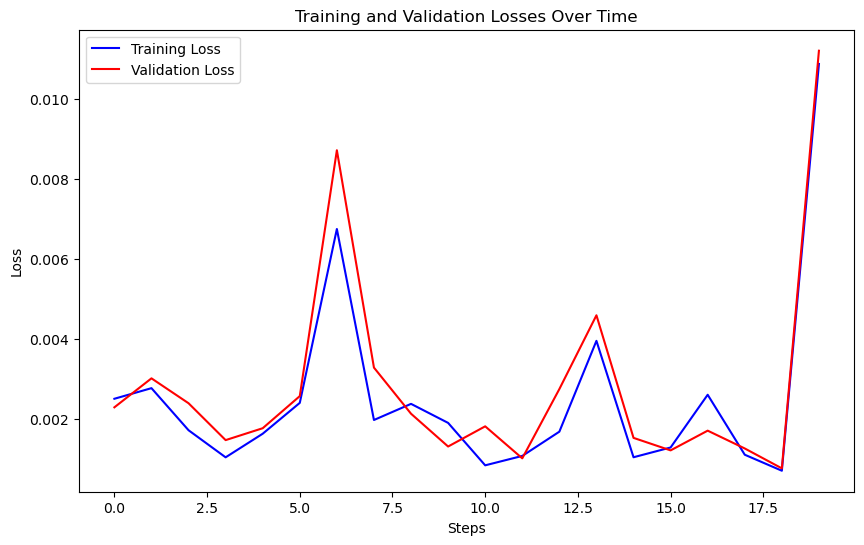

In [17]:
#optimizer = optim.SGD(model.parameters(), lr=1e-4)
loop(epochs_so_far)

In [85]:
#save_model(MODEL_PATH, model, optimizer, model.class_params(), epochs_so_far[0], tr_losses[-1], v_losses[-1])
save_model(MODEL_PATH, model, optimizer, model.class_params(), epochs_so_far[0], 10, 10)

In [36]:


model.eval()
train_loss = split_loss('train')
print(f'train loss: {train_loss}')
val_loss = split_loss('val')
print(f'val loss: {val_loss}')
model.train()

train loss: 0.5786431634062251
val loss: 0.5792259630075721


ConvNet_1D(
  (emb): Embedding(49, 24)
  (ConvNet): Sequential(
    (0): Conv1d(24, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
    (13): ReLU()
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): MaxPool1d(kernel_size=5,

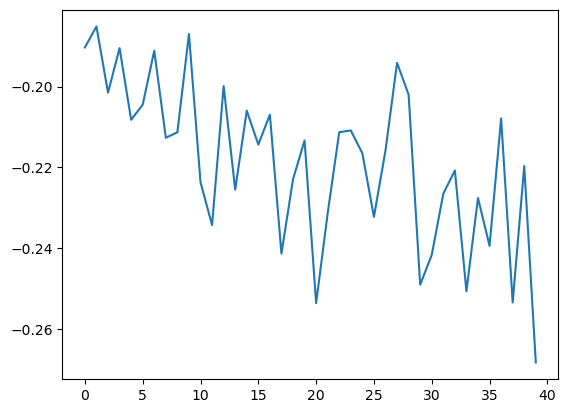

In [38]:
plt.plot(torch.tensor(lossi).view(-1, 10).mean(1))

weight (32, 24, 3) | mean -0.003225 | std 5.837443e-02 | grad:data ratio 8.623674e-01
weight (64, 32, 3) | mean -0.002162 | std 2.657932e-02 | grad:data ratio 4.476981e-01
weight (128, 64, 3) | mean -0.000452 | std 1.146417e-02 | grad:data ratio 2.754538e-01
weight (256, 128, 3) | mean +0.000039 | std 5.758521e-03 | grad:data ratio 1.952789e-01


/tmp/ipykernel_6460/2606801353.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hy, hx = torch.histogram(torch.tensor(t, device='cpu'), density=True)


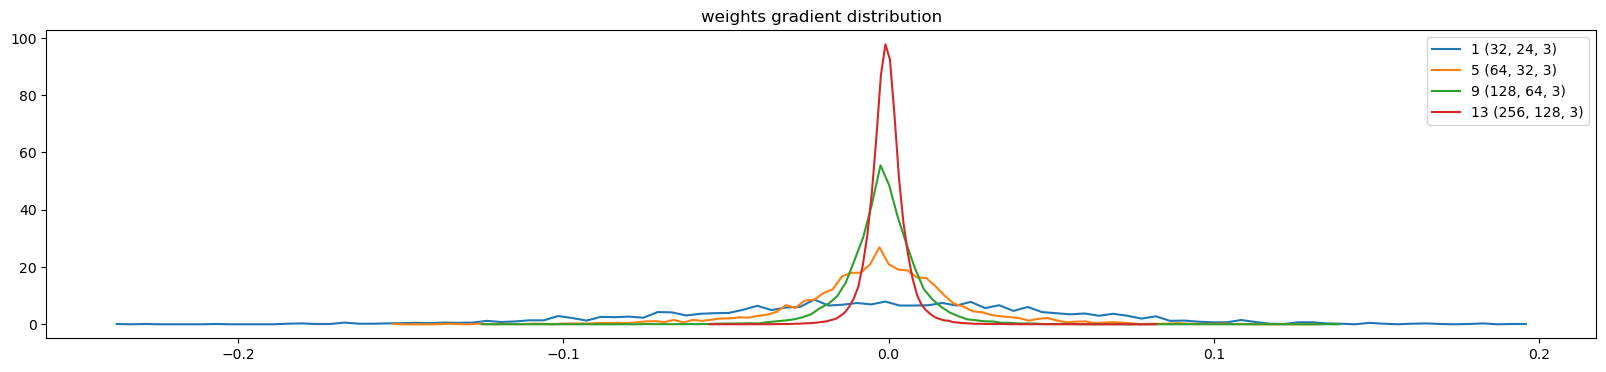

In [39]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters()):
    t = p.grad
    # Conv1D
    if p.ndim == 3:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(torch.tensor(t, device='cpu'), density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

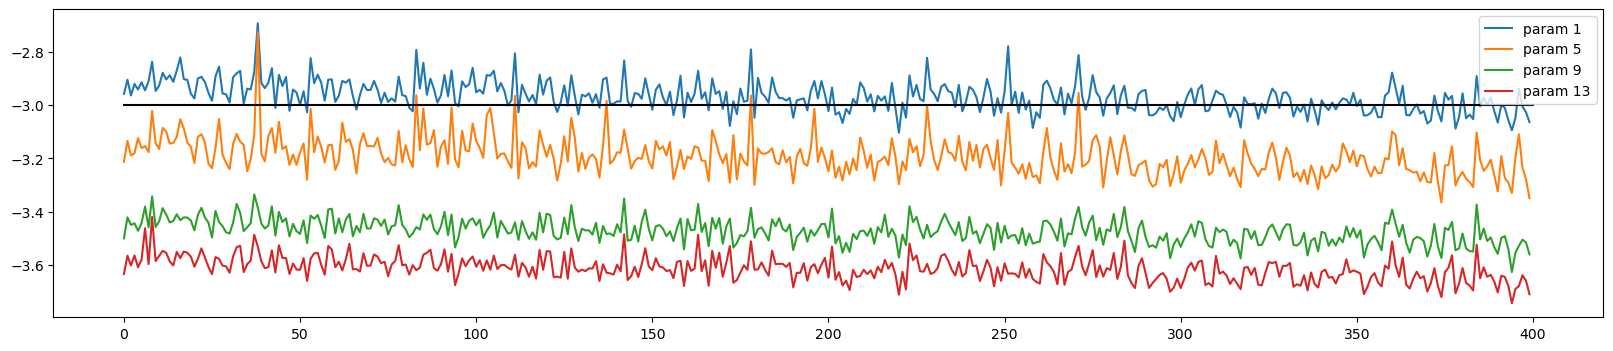

In [40]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
    # Conv1D
    if p.ndim == 3:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [22]:
model.eval()
test_loss = split_loss('test')
print(f'test loss: {test_loss}')
model.train()

test loss: 0.001620603323866151


ConvNet_1D(
  (emb): Embedding(49, 8)
  (ConvNet): Sequential(
    (0): Conv1d(8, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (9): ReLU()
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
    (13): ReLU()
    (14): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): MaxPool1d(kernel_size=5, s

In [95]:
ll = torch.tensor([[-0.0375, -0.1068],
        [ 0.1112, -0.0455],
        [ 0.1011, -0.0865],
        [ 0.0995, -0.0558],
        [ 0.0602, -0.0353],
        [ 0.0600, -0.0823],
        [-0.0159, -0.0931],
        [ 0.0879, -0.0448],
        [ 0.0349, -0.0411],
        [ 0.0874, -0.0459],
        [ 0.1117, -0.0387],
        [ 0.1172, -0.0799],
        [ 0.0905, -0.0803],
        [ 0.0985, -0.0687],
        [ 0.0905, -0.0672],
        [ 0.0854, -0.0588],
        [ 0.0992, -0.0443],
        [ 0.1238, -0.0592],
        [ 0.0984, -0.0906],
        [ 0.0800, -0.1271],
        [ 0.0928, -0.0344],
        [ 0.0976, -0.0857],
        [ 0.0655, -0.0329],
        [ 0.1006, -0.0647],
        [ 0.0947, -0.0456],
        [ 0.0842, -0.0464],
        [ 0.0788, -0.0704],
        [ 0.0975, -0.0575],
        [ 0.1150, -0.0741],
        [ 0.0682, -0.0127],
        [ 0.0181, -0.0308],
        [ 0.0883, -0.0687]])

In [96]:
yy = torch.tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 1])

In [106]:
F.cross_entropy(ll, yy)

tensor(0.7241)

In [121]:
ll.softmax(dim=1)

tensor([[0.5173, 0.4827],
        [0.5391, 0.4609],
        [0.5468, 0.4532],
        [0.5387, 0.4613],
        [0.5239, 0.4761],
        [0.5355, 0.4645],
        [0.5193, 0.4807],
        [0.5331, 0.4669],
        [0.5190, 0.4810],
        [0.5333, 0.4667],
        [0.5375, 0.4625],
        [0.5491, 0.4509],
        [0.5426, 0.4574],
        [0.5417, 0.4583],
        [0.5393, 0.4607],
        [0.5360, 0.4640],
        [0.5358, 0.4642],
        [0.5456, 0.4544],
        [0.5471, 0.4529],
        [0.5516, 0.4484],
        [0.5318, 0.4682],
        [0.5457, 0.4543],
        [0.5246, 0.4754],
        [0.5412, 0.4588],
        [0.5350, 0.4650],
        [0.5326, 0.4674],
        [0.5372, 0.4628],
        [0.5387, 0.4613],
        [0.5471, 0.4529],
        [0.5202, 0.4798],
        [0.5122, 0.4878],
        [0.5392, 0.4608]])

In [15]:
for k, v in pitch_data.items():
    print(f'{k} -> {len(v.pitches)}')
# ../../data/simple-test/pitch_data/saveri/tmk-saveri_D3
# ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3


../../data/simple-test/pitch_data/hemavati/trichur-hemavati-alapana_C#3_minus_1 -> 96236
../../data/simple-test/pitch_data/hemavati/trichur-hemavati-alapana_C#3_plus_1 -> 96236
../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3 -> 160051
../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_plus_3 -> 160051
../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_minus_1 -> 160051
../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_minus_2 -> 160051
../../data/simple-test/pitch_data/hemavati/trichur-hemavati-alapana_C#3_plus_3 -> 96236
../../data/simple-test/pitch_data/hemavati/trichur-hemavati-alapana_C#3 -> 96236
../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_plus_2 -> 160051
../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_plus_1 -> 160051
../../data/simple-test/pitch_data/hemavati/trichur-hemavati-alapana_C#3_plus_2 -> 96236
../../data/simple-test/pitch_data/saveri/nedunuri-amma-nannubrovave_A3_minus_1 -> 37473
../../data/simp

In [57]:
from collections import Counter
from scipy.spatial import distance
from dtaidistance import dtw

def plot_element_counts(data):
    """
    Count the occurrences of each element in the data, sort the counts in descending order, and plot them.

    Parameters:
    - data: List of data points
    """
    data = [itos[x] for x in data]
    # Count the occurrences of each element
    counts = Counter(data)

    # Sort the counts in descending order
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

    # Separate the elements and their counts
    elements, count_values = zip(*sorted_counts)

    # Plot the counts
    plt.figure(figsize=(10, 6))
    plt.bar(elements, count_values)
    plt.xlabel('Element')
    plt.ylabel('Count')
    plt.title('Element Counts in Descending Order')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()
    
def table_pitch_counts(data1, data2):
    data1, data2 = [itos[x] for x in data1], [itos[x] for x in data2]
    counts1, counts2 = Counter(data1), Counter(data2)
    for k, _ in counts1.items():
        counts1[k] = counts1[k] / len(data1)
    for k, _ in counts2.items():
        counts2[k] = counts2[k] / len(data2)
    sorted_counts = sorted(counts1.items(), key=lambda x: x[1], reverse=True)
    elements, count_values = zip(*sorted_counts)
    
    for k, v in sorted_counts:
        v1 = v * 100
        el = counts2[k] * 100 if k in counts2 else 0
        print(f'{k} -> {v1:2f} - {el:2f}')
        
def get_pitch_counts(data):
    data1 = [itos[x] for x in data]
    counts1 = Counter(data1)
    for k, _ in counts1.items():
        counts1[k] = counts1[k] / len(data1)
    sorted_counts = sorted(counts1.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_counts
        
def euclidean_dist(data1, data2):
    return distance.euclidean(data1, data2)

def dynamic_time_warping_dist(data1, data2):
    distance, _, _, _ = dtw.distance(data1, data2)
    return distance

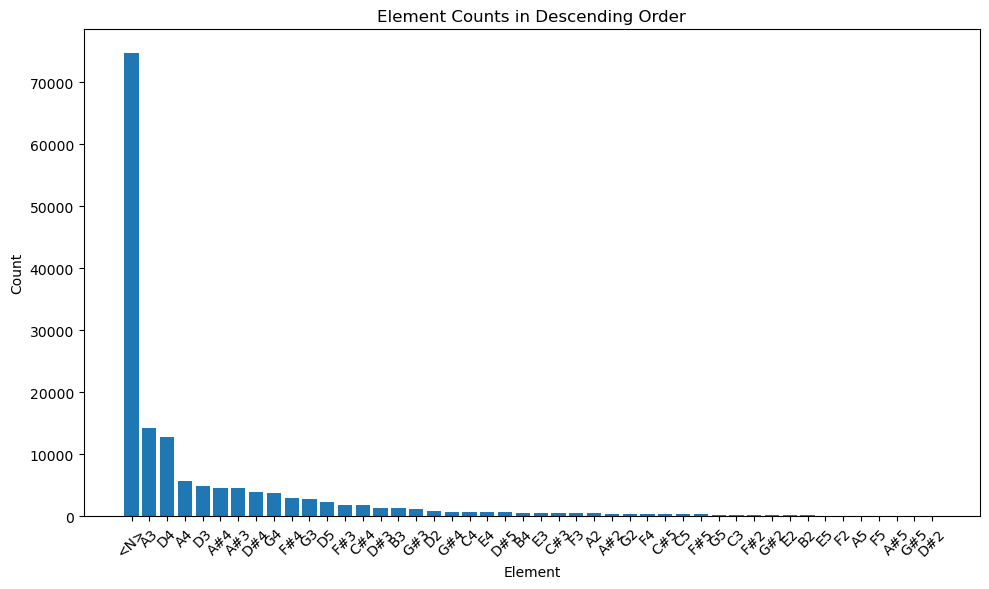

In [28]:
saveri_test = pitch_data['../../data/simple-test/pitch_data/saveri/tmk-saveri_D3'].pitches
hemavati_test = pitch_data['../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3'].pitches

plot_element_counts(saveri_test)

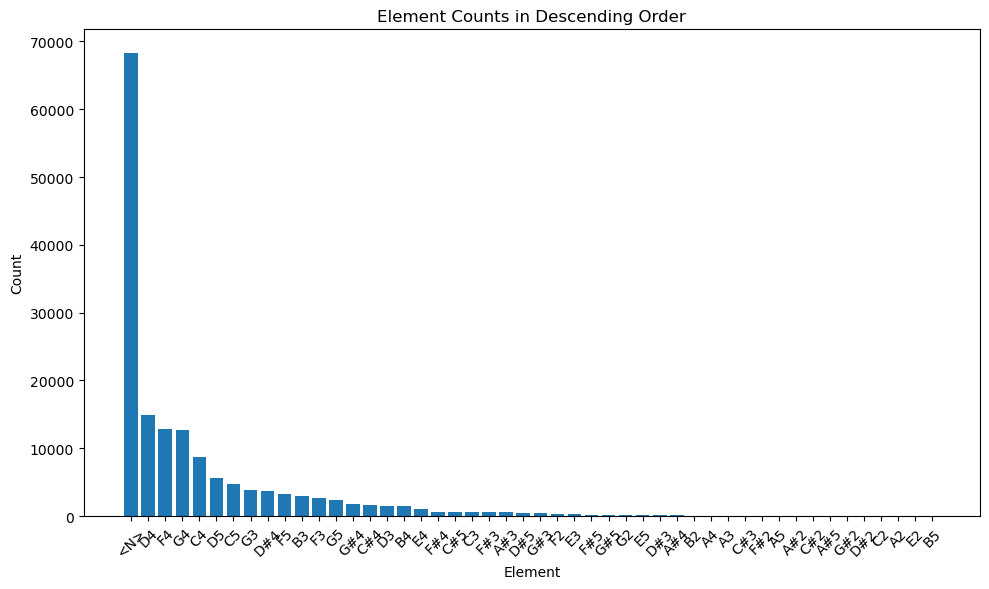

In [29]:
plot_element_counts(hemavati_test)

In [41]:
table_pitch_counts(saveri_test, hemavati_test)

<N> -> 48.932982 - 42.718883
A3 -> 9.246183 - 0.044986
D4 -> 8.334588 - 9.333900
A4 -> 3.738000 - 0.045610
D3 -> 3.180441 - 0.967192
A#4 -> 2.950088 - 0.069353
A#3 -> 2.925875 - 0.338642
D#4 -> 2.554823 - 2.304890
G4 -> 2.450117 - 7.963087
F#4 -> 1.953419 - 0.395499
G3 -> 1.792434 - 2.439222
D5 -> 1.484206 - 3.482640
F#3 -> 1.155037 - 0.383003
C#4 -> 1.122316 - 1.032796
D#3 -> 0.852698 - 0.087472
B3 -> 0.827176 - 1.891897
G#3 -> 0.753882 - 0.281785
D2 -> 0.485573 - 0.000000
G#4 -> 0.469213 - 1.109021
C4 -> 0.415551 - 5.462009
E4 -> 0.415551 - 0.606057
D#5 -> 0.381522 - 0.299280
B4 -> 0.367125 - 0.925330
E3 -> 0.364507 - 0.157450
C#3 -> 0.304956 - 0.039362
F3 -> 0.291868 - 1.654473
A2 -> 0.268963 - 0.001874
A#2 -> 0.265037 - 0.010622
G2 -> 0.253912 - 0.108091
F4 -> 0.250640 - 7.978082
C#5 -> 0.217265 - 0.393625
C5 -> 0.178654 - 2.919694
F#5 -> 0.169493 - 0.124960
G5 -> 0.092926 - 1.502646
C3 -> 0.090963 - 0.389876
F#2 -> 0.084419 - 0.038738
G#2 -> 0.070676 - 0.004998
E2 -> 0.064787 - 0.

In [53]:
table_pitch_counts(saveri_test, saveri_test_2)

<N> -> 48.932982 - 81.170261
A3 -> 9.246183 - 0.114613
D4 -> 8.334588 - 0.509727
A4 -> 3.738000 - 0.021113
D3 -> 3.180441 - 0.012065
A#4 -> 2.950088 - 0.096516
A#3 -> 2.925875 - 0.138742
D#4 -> 2.554823 - 0.431307
G4 -> 2.450117 - 0.012065
F#4 -> 1.953419 - 9.009199
G3 -> 1.792434 - 0.018097
D5 -> 1.484206 - 0.015081
F#3 -> 1.155037 - 0.515759
C#4 -> 1.122316 - 5.429045
D#3 -> 0.852698 - 0.012065
B3 -> 0.827176 - 0.358920
G#3 -> 0.753882 - 0.009048
D2 -> 0.485573 - 0.000000
G#4 -> 0.469213 - 0.009048
C4 -> 0.415551 - 0.398130
E4 -> 0.415551 - 0.078420
D#5 -> 0.381522 - 0.000000
B4 -> 0.367125 - 0.174936
E3 -> 0.364507 - 0.000000
C#3 -> 0.304956 - 0.009048
F3 -> 0.291868 - 0.045242
A2 -> 0.268963 - 0.009048
A#2 -> 0.265037 - 0.003016
G2 -> 0.253912 - 0.000000
F4 -> 0.250640 - 0.180968
C#5 -> 0.217265 - 0.464485
C5 -> 0.178654 - 0.033177
F#5 -> 0.169493 - 0.316694
G5 -> 0.092926 - 0.000000
C3 -> 0.090963 - 0.018097
F#2 -> 0.084419 - 0.262404
G#2 -> 0.070676 - 0.003016
E2 -> 0.064787 - 0.

In [52]:
saveri_test_2 = pitch_data['../../data/simple-test/pitch_data/saveri/bombaysis-balamu-kulamu_F#3'].pitches
saveri_test_3 = pitch_data['../../data/simple-test/pitch_data/saveri/arunasairam-muruga-muruga_F3'].pitches

table_pitch_counts(saveri_test_2, saveri_test_3)

<N> -> 81.170261 - 51.979276
F#4 -> 9.009199 - 2.098615
C#4 -> 5.429045 - 9.168704
F#3 -> 0.515759 - 1.536849
D4 -> 0.509727 - 2.529398
C#5 -> 0.464485 - 0.000000
D#4 -> 0.431307 - 0.293981
C4 -> 0.398130 - 13.264059
B3 -> 0.358920 - 2.634183
F#5 -> 0.316694 - 0.000000
F#2 -> 0.262404 - 0.372570
F4 -> 0.180968 - 10.268949
B4 -> 0.174936 - 0.005821
A#3 -> 0.138742 - 2.692397
A3 -> 0.114613 - 0.844103
B2 -> 0.102549 - 0.174642
A#4 -> 0.096516 - 0.151356
E4 -> 0.078420 - 0.261963
F3 -> 0.045242 - 0.718943
C5 -> 0.033177 - 0.000000
A4 -> 0.021113 - 0.139714
G3 -> 0.018097 - 0.032018
C3 -> 0.018097 - 0.250320
D5 -> 0.015081 - 0.000000
A#5 -> 0.015081 - 0.000000
D3 -> 0.012065 - 0.002911
D#3 -> 0.012065 - 0.000000
G4 -> 0.012065 - 0.203749
G#3 -> 0.009048 - 0.014553
G#4 -> 0.009048 - 0.032018
C#3 -> 0.009048 - 0.151356
A2 -> 0.009048 - 0.005821
G#2 -> 0.003016 - 0.000000
A#2 -> 0.003016 - 0.128071
F5 -> 0.003016 - 0.000000


In [68]:
for k, v in pitch_data.items():
    print(f'Raga file: {k}')
    top_5 = get_pitch_counts(v.pitches)[:5]
    for t in top_5:
        val = t[1] * 100
        print(f'Note: {t[0]}, percentage: {val:.2f}')

Raga file: ../../data/simple-test/pitch_data/hemavati/trichur-hemavati-alapana_C#3_minus_1
Note: C4, percentage: 18.74
Note: A3, percentage: 18.24
Note: D4, percentage: 13.00
Note: G3, percentage: 11.53
Note: A#3, percentage: 6.12
Raga file: ../../data/simple-test/pitch_data/hemavati/trichur-hemavati-alapana_C#3_plus_1
Note: D4, percentage: 18.60
Note: B3, percentage: 18.13
Note: E4, percentage: 13.07
Note: A3, percentage: 11.33
Note: C4, percentage: 6.80
Raga file: ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3
Note: D4, percentage: 16.29
Note: F4, percentage: 13.93
Note: G4, percentage: 13.90
Note: C4, percentage: 9.54
Note: D5, percentage: 6.08
Raga file: ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_plus_3
Note: F4, percentage: 16.11
Note: A#4, percentage: 15.04
Note: G#4, percentage: 14.72
Note: D#4, percentage: 9.52
Note: F5, percentage: 5.43
Raga file: ../../data/simple-test/pitch_data/hemavati/aruna-hemavati_F3_minus_1
Note: C#4, percentage: 14.93
N

In [8]:
ytrain_numpy = np.array(Ytrain)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(ytrain_numpy), y=ytrain_numpy)
class_weights = torch.tensor(class_weights, device=device, dtype=torch.float32)
print(f'From sklearn: {class_weights}')

sample_weights = [class_weights[t] for t in Ytrain]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(Ytrain), replacement=True)
dataset = MyDataset(Xtrain, torch.tensor(Ytrain, device=device))
data_loader = DataLoader(dataset, batch_size=32, sampler=sampler)

NameError: name 'Ytrain' is not defined

In [184]:
# count = 0
# v = torch.zeros(2, device=device)
# for _ in range(1):
#     for inp, lab in data_loader:
#         #print(f'Input: {inp.shape}, label: {len(lab)}')
#         v += lab.bincount()
#         #print(f'bincount: {lab.bincount()}')
#         count += len(lab)
#         if count >= 100000:
#             break
# print(f'v: {v}')

data_iterator = iter(data_loader)

In [28]:
# Example usage
in_channels = 1  # Input channels (e.g., single-channel audio)
out_channels = 2  # Output channels (e.g., regression output)
kernel_size = 3   # Kernel size
stride = 1       # Stride
padding = 0      # Padding
n_tokens = vocab_size
n_embd = 8
hidden_size = 32
num_layers = 2

# # Learning rate
lr = 1e-1
# epochs = 0
epochs_so_far = [0]
model = LSTMNet(out_channels, n_embd, n_tokens,hidden_size, num_layers, device=device)
#optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
optimizer = optim.SGD(model.parameters(), lr=lr)

MODEL_PATH = '../models/lstm-3-no-noise-token-2-layers'
if os.path.exists(MODEL_PATH):
    print('Model exists: Loading')
    IMPORT_PATH = '../models/lstm-1-epochs-[200000]'
    checkpoint = torch.load(IMPORT_PATH)
    epochs_so_far[0] = checkpoint['epochs']
    train_loss = checkpoint['train_loss']
    val_loss = checkpoint['val_loss']
    print(f'checkpoint after epoch: {epochs_so_far[0]}')
    print(f'train loss: {train_loss}')
    print(f'val loss: {val_loss}')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    print(f'Creating new model')
    
model.train()
batch_size = 32
lossi = []
tr_losses = []
v_losses = []
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")
print(f'Epochs trained so far: {epochs_so_far[0]}')
ud = []
# Example input - First dimension is number of minibatches, second is embedding dimension, third is context size
#input_tensor = torch.randint(0, n_tokens, (32, 2700), device=device)  # Batch size, channels, sequence length
#logits = model(input_tensor)
#loss = F.cross_entropy(logits, torch.randint(0, out_channels, (32,), device=device))
#print(f'output shape {output.shape}')
#print(f'logits: {logits.shape}')
#print(f'loss: {loss}')
#total_params = sum(param.numel() for param in model.parameters())
#print(f'total params {total_params}')

#for p in model.parameters():
#    p.grad = None
#loss.backward()   

Creating new model
Total number of parameters: 17718
Epochs trained so far: 0


# Dimensionality computation

input shape: torch.Size([32, 2700])
after emb shape: torch.Size([32, 2700, 8])
after view shape: torch.Size([32, 8, 2700])

32,8,2700
conv1d -> 8, 32, 3
Output size -> 32, 32, 2698
MaxPool1D -> 32, 32, 539

conv1d -> 32, 64, 3
output -> 32, 64, 537
maxpool1d -> 32, 64, 107

conv1d -> 64, 128, 3
output -> 32, 128, 105
maxpool1d -> 32, 128, 21

conv1d -> 128, 256, 3
output -> 32, 256, 19
maxpool1d -> 32, 256, 3
Flatten -> 32, 256 * 3 -> 32, 768
after conv shape: torch.Size([32, 768])